## Colocating Sentinel-3 OLCI and Sentinal-2 Optical Data
Before implementing regression analysis, we need to get pixel-level colocated images. The following codes set out a step-by-step instruction.

### 1. Read in functions
This cell includes all functions needed for this notebook. Make sure to install relevant packages using `pip install`.

In [ ]:
pip install scikit-image

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.signal import correlate2d
from scipy.spatial import cKDTree
import os
import netCDF4
from netCDF4 import Dataset
import re
import rasterio
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from pyproj import Proj, transform
from skimage import exposure  # Import exposure module from skimage


### 2. Importing and Preprocessing Data

The following cells import and preprocess Sentinel-2 Optical Data.

In [ ]:
# Paths to the band images
path = '/Users/rhoswen/Desktop/Year_3/GEOL0069/Week_6/' # You need to specify the path
base_path = "S2_data/S2B_MSIL2A_20180610T063629_N0500_R120_T48XWM_20230717T031427.SAFE/GRANULE/L2A_T48XWM_A006581_20180610T063623/IMG_DATA/R10m/"
bands_paths = {
    'B4': path + base_path + 'T48XWM_20180610T063629_B04_10m.jp2',
    'B3': path + base_path + 'T48XWM_20180610T063629_B03_10m.jp2',
    'B2': path + base_path + 'T48XWM_20180610T063629_B02_10m.jp2'
}

# Read and stack the band images
band_data = []
for band in ['B4', 'B3', 'B2']:
    with rasterio.open(bands_paths[band]) as src:
        band_data.append(src.read(1))

# Stack bands and create a mask for valid data (non-zero values in all bands)
band_stack = np.dstack(band_data)
valid_data_mask = np.all(band_stack > 0, axis=2)

# Reshape for GMM, only including valid data
X = band_stack[valid_data_mask].reshape((-1, 3))

# Check the shapes for each processed dataset
print(f"band stack shape:", band_stack.shape)
print(f"valid data shape:", valid_data_mask.shape)
print(f"reshaped data shape:", X.shape)

# Save the band stack data
np.save(path+'band_stack.npy',band_stack)

In [ ]:
#This is the code to extract projection and coordinates (lon,lat,x,y) of S2 imagery

# Path to the Sentinel-2 JP2 image file
path = '/Users/rhoswen/Desktop/Year_3/GEOL0069/Week_6/' # You need to specify the path
s2_filename = path + 'S2_data/S2B_MSIL2A_20180610T063629_N0500_R120_T48XWM_20230717T031427.SAFE/GRANULE/L2A_T48XWM_A006581_20180610T063623/IMG_DATA/R10m/T48XWM_20180610T063629_B04_10m.jp2'

# Read the Sentinel-2 image and its geospatial information
with rasterio.open(s2_filename) as src:
    # Read the raster data and the affine transformation
    s2_data = src.read(1)
    transform_matrix = src.transform

    # Get the spatial reference system (CRS)
    srs = src.crs

# Create grid of X,Y values
rows, cols = s2_data.shape
x_s2, y_s2 = [], []
for row in range(rows):
    print(row)
    for col in range(cols):
        x, y = transform_matrix * (col, row)
        x_s2.append(x)
        y_s2.append(y)

# Convert grid of X,Y values to latitude/longitude
in_proj = Proj(init=str(srs))  # Initialize projection from CRS
out_proj = Proj(proj='latlong')  # Initialize projection for latitude/longitude
lon_s2, lat_s2 = transform(in_proj, out_proj, x_s2, y_s2)
x_s2, y_s2 = transform(out_proj, in_proj, lon_s2, lat_s2)

# Check the lengths for each processed dataset
print(f"row arrays length:", len(x_s2))
print(f"column arrays length:", len(y_s2))
print(f"longitude arrays length:", len(lon_s2))
print(f"latitude arrays length:", len(lat_s2))

# Save the full coordinates in rows and columns
np.save(path+'x_s2.npy', x_s2)
np.save(path+'y_s2.npy', y_s2)

Next is to import and preprocess Sentinel-3 OLCI Data.

In [19]:
# Define the path to the main folder where your data is stored.
# You need to replace 'path/to/data' with the actual path to your data folder.
main_folder_path = '/Users/rhoswen/Desktop/Year_3/GEOL0069/Week_6/OLCI_data/'
# This part of the code is responsible for finding all directories in the main_folder that end with '.SEN3'.
# '.SEN3' is the format of the folder containing specific satellite data files (in this case, OLCI data files).
directories = [d for d in os.listdir(main_folder_path) if os.path.isdir(os.path.join(main_folder_path, d)) and d.endswith('002.SEN3')] #load OLCI imagery

# Loop over each directory (i.e., each set of data) found above.
for directory in directories:
    # Construct the path to the OLCI data file within the directory.
    # This path is used to access the data files.
    OLCI_file_p = os.path.join(main_folder_path, directory)

    # Print the path to the current data file being processed.
    # This is helpful for tracking which file is being processed at any time.
    print(f"Processing: {OLCI_file_p}")

    # Load the instrument data from a file named 'instrument_data.nc' inside the directory.
    # This file contains various data about the instrument that captured the satellite data.
    instrument_data = netCDF4.Dataset(OLCI_file_p + '/instrument_data.nc')
    solar_flux = instrument_data.variables['solar_flux'][:]  # Extract the solar flux data.
    detector_index = instrument_data.variables['detector_index'][:]  # Extract the detector index.

    # Load tie geometries from a file named 'tie_geometries.nc'.
    # Tie geometries contain information about viewing angles, which are important for data analysis.
    tie_geometries = netCDF4.Dataset(OLCI_file_p + '/tie_geometries.nc')
    SZA = tie_geometries.variables['SZA'][:]  # Extract the Solar Zenith Angle (SZA).

    # Create a directory for saving the processed data using the original directory name.
    # This directory will be used to store output files.
    save_directory = os.path.join('path/to/save', directory)
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    # This loop processes each radiance band in the OLCI data.
    # OLCI instruments capture multiple bands, each representing different wavelengths.
    OLCI_data = []
    for Radiance in range(1, 22):  # There are 21 bands in OLCI data.
    # for Radiance in [2,5,8,16]:  # selecting relevant bands

        Rstr = "%02d" % Radiance  # Formatting the band number.
        solar_flux_band = solar_flux[Radiance - 1]  # Get the solar flux for the current band.

        # Print information about the current band being processed.
        # This includes the band number and its corresponding solar flux.
        print(f"Processing Band: {Rstr}")
        print(f"Solar Flux for Band {Rstr}: {solar_flux_band}")

        # Load radiance values from the OLCI data file for the current band.
        OLCI_nc = netCDF4.Dataset(OLCI_file_p + '/Oa' + Rstr + '_radiance.nc')
        radiance_values = np.asarray(OLCI_nc['Oa' + Rstr + '_radiance'])

        # Initialize an array to store angle data, which will be calculated based on SZA.
        angle = np.zeros_like(radiance_values)
        for x in range(angle.shape[1]):
            angle[:, x] = SZA[:, int(x/64)]

        # Calculate the Top of Atmosphere Bidirectional Reflectance Factor (TOA BRF) for the current band.
        TOA_BRF = (np.pi * radiance_values) / (solar_flux_band[detector_index] * np.cos(np.radians(angle)))

        # Add the calculated TOA BRF data to the OLCI_data list.
        OLCI_data.append(TOA_BRF)

        # Print the range of reflectance values for the current band.
        print(f"Reflectance Values Range for Band {Rstr}: {np.nanmin(TOA_BRF)}, {np.nanmax(TOA_BRF)}")
            
    # Reshape the OLCI_data array for further analysis or visualization.
    reshaped_array = np.moveaxis(np.array(OLCI_data), 0, -1)
    print("Reshaped array shape:", reshaped_array.shape)
    # Save the reshaped array
    np.save(main_folder_path+'reshaped_array.npy',reshaped_array)

    # Split the reshaped array into smaller chunks along the second dimension.
    # This can be useful for handling large datasets more efficiently.
    split_arrays = np.array_split(reshaped_array, 5, axis=1)

    # Save each chunk of data separately.
    # This is helpful for processing or analyzing smaller portions of data at a time.
    for i, arr in enumerate(split_arrays):
        print(f"Chunk {i+1} shape:", arr.shape)
        save_path = os.path.join(save_directory, f"chunk_{i+1}_band_{Rstr}.npy")
        np.save(save_path, arr)
        print(f"Saved Chunk {i+1} for Band {Rstr} to {save_path}")

    # Extract OLCI longitude and latitude coordinates
    OLCI_coord = netCDF4.Dataset(OLCI_file_p + '/geo_coordinates.nc')
    OLCI_lon=OLCI_coord['longitude']
    OLCI_lat=OLCI_coord['latitude']

    # Check the shapes of OLCI longitude and latitude data
    print(f"OLCI longitude shape:", OLCI_lon.shape)
    print(f"OLCI latitude shape:", OLCI_lat.shape)

Processing: /Users/rhoswen/Desktop/Year_3/GEOL0069/Week_6/OLCI_data/S3A_OL_1_EFR____20180610T061544_20180610T061844_20180611T110424_0179_032_134_1620_LN1_O_NT_002.SEN3


Processing Band: 01
Solar Flux for Band 01: [1475.2358 1475.2004 1475.1652 ... 1469.0225 1468.9977 1468.9728]
Reflectance Values Range for Band 01: 0.17626383900642395, 300.45330810546875
Processing Band: 02
Solar Flux for Band 02: [1659.1288 1659.1207 1659.1128 ... 1655.9012 1655.8939 1655.8865]
Reflectance Values Range for Band 02: 0.15948812663555145, 266.53863525390625
Processing Band: 03
Solar Flux for Band 03: [1841.704  1841.6724 1841.6407 ... 1830.435  1830.4143 1830.3936]
Reflectance Values Range for Band 03: 0.1234382838010788, 241.1272430419922
Processing Band: 04
Solar Flux for Band 04: [1883.2373 1883.2175 1883.1979 ... 1875.6531 1875.6427 1875.6326]
Reflectance Values Range for Band 04: 0.0848676934838295, 235.3114013671875
Processing Band: 05
Solar Flux for Band 05: [1857.4269 1857.4463 1857.4657 ... 1864.4468 1864.4581 1864.4695]
Reflectance Values Range for Band 05: 0.07181159406900406, 236.7202911376953
Processing Band: 06
Solar Flux for Band 06: [1740.4172 1740.4253 

In [ ]:
# Convert longitude and latitude into x and y coordinates
x_s3, y_s3 = transform(out_proj, in_proj, OLCI_lon, OLCI_lat)

# Assuming x_s3 and y_s3 are MaskedArray objects, convert them to regular NumPy arrays
x_s3_data = x_s3.data if hasattr(x_s3, 'data') else x_s3
y_s3_data = y_s3.data if hasattr(y_s3, 'data') else y_s3

# Check the lengths of each coordinate
print(f"x arrays length:", len(x_s3_data))
print(f"y arrays length:", len(y_s3_data))

# Save the x and y coordinates arrays
np.save(main_folder_path+'x_s3.npy', x_s3_data)
np.save(main_folder_path+'y_s3.npy', y_s3_data)

In [ ]:
# This plot is to show that most of the S3 data may not be useful due to cloud coverage
plt.pcolor(reshaped_array[::10,::10,2],vmin=0,vmax=1)
plt.colorbar()

### 3. Loading processed data

This cell is used to load all the preprocessed data in previous steps for analysis.

In [20]:
path = '/Users/rhoswen/Desktop/Year_3/GEOL0069/Week_6/' # You need to specify the path
x_s2=np.load(path+'x_s2.npy')
y_s2=np.load(path+'y_s2.npy')
band_stack=np.load(path+'band_stack.npy')

x_s3=np.load(path+'x_s3.npy')
y_s3=np.load(path+'y_s3.npy')
reshaped_array=np.load(path+'reshaped_array.npy')

We can also verify if Sentinel-2 data is indeed within Sentinel-3 OLCI data.

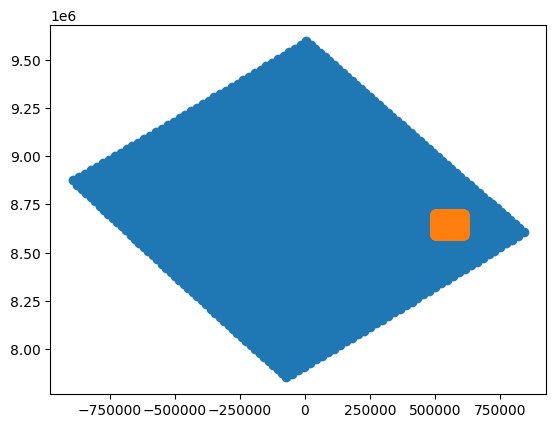

In [40]:
s1=100 #subsampling rate for S2
s2=100 #subsampling rate for s3

plt.scatter(x_s3[::s1,::s1],y_s3[::s1,::s1])
plt.scatter(np.asarray(x_s2).reshape(10980,10980)[::s2,::s2],np.asarray(y_s2).reshape(10980,10980)[::s2,::s2])

### 4. Define overlap region

As the full image is too large, we need to confined a region for analysis. The following code is to define and plot the desired overlap region before colocating the images.

x_s3_condition shape: (125766,)
y_s3_condition shape: (125766,)
reshaped_array_condition shape: (125766, 21)


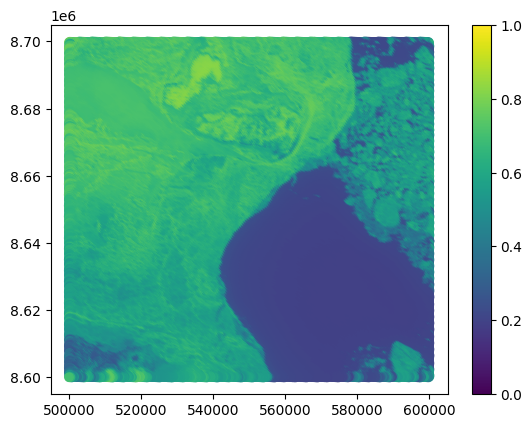

In [46]:
# Define and plot region for zoom-in Sentinel-3 OLCI image
condition_s3 = (x_s3 > 500000) & (x_s3 < 600000) & (y_s3 > 8600000) & (y_s3 < 8700000)

# Assign the condition to new parameters
x_s3_condition, y_s3_condition = x_s3[condition_s3], y_s3[condition_s3]
reshaped_array_condition = reshaped_array[condition_s3] # select one band

# Plot the zoom-in image
plt.scatter(x_s3_condition,y_s3_condition,c=reshaped_array_condition[:,0],vmin=0,vmax=1)
plt.colorbar()

# Check conditioned paramerters shape
print(f'x_s3_condition shape:', x_s3_condition.shape)
print(f'y_s3_condition shape:', y_s3_condition.shape)
print(f'reshaped_array_condition shape:', reshaped_array_condition.shape)

x_s2_condition shape: (99991002,)
y_s2_condition shape: (99991002,)
band_stack_condition shape: (99991002,)


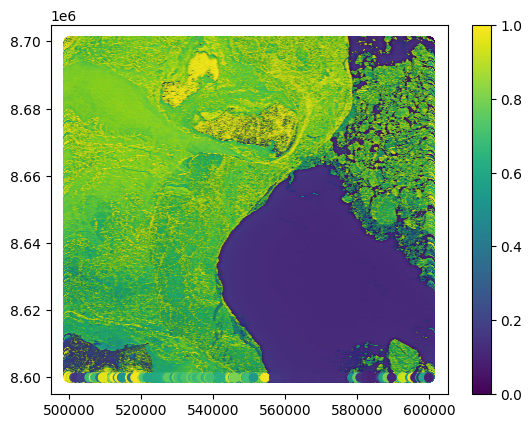

In [47]:
# Define and plot Sentinel-2 image (This may take a little bit longer)
# Reshape 1d array into 2d
x_s2bis=np.asarray(x_s2).reshape(10980,10980)
y_s2bis=np.asarray(y_s2).reshape(10980,10980)

# Define condition and assign to new parameters
condition_s2 = (x_s2bis > 500000) & (x_s2bis < 600000) & (y_s2bis > 8600000) & (y_s2bis < 8700000)
x_s2_condition, y_s2_condition= x_s2bis[condition_s2], y_s2bis[condition_s2]
band_stack_condition = band_stack[condition_s2,2]/10000

# Plot the s2 image
plt.scatter(x_s2_condition,y_s2_condition,c=band_stack_condition,vmin=0,vmax=1)
plt.colorbar()

# Check conditioned paramerters shape
print(f'x_s2_condition shape:', x_s2_condition.shape)
print(f'y_s2_condition shape:', y_s2_condition.shape)
print(f'band_stack_condition shape:', band_stack_condition.shape)

In [48]:
# Save the conditioned parameters
# Replace the path
path = '/Users/rhoswen/Desktop/Year_3/GEOL0069/Week_6/'
# s3 image parameters
np.save(path+'x_s3_condition.npy',x_s3_condition)
np.save(path+'y_s3_condition.npy',y_s3_condition)
np.save(path+'reshaped_array_condition.npy',reshaped_array_condition)
# s2 image parameters
np.save(path+'x_s2_condition.npy',x_s2_condition)
np.save(path+'y_s2_condition.npy',y_s2_condition)
np.save(path+'band_stack_condition.npy',band_stack_condition)

The following code is optional incase for any interruption may occur, and we can restart from here by reloading the data.

In [2]:
# (optional) Reload the conditioned parameters if starting here
# Replace the path
path = '/Users/rhoswen/Desktop/Year_3/GEOL0069/Week_6/'
# s3 paramters
x_s3_condition=np.load(path+'x_s3_condition.npy')
y_s3_condition=np.load(path+'y_s3_condition.npy')
reshaped_array_condition=np.load(path+'reshaped_array_condition.npy')
# s2 parameters
x_s2_condition=np.load(path+'x_s2_condition.npy')
y_s2_condition=np.load(path+'y_s2_condition.npy')
band_stack_condition=np.load(path+'band_stack_condition.npy')

### 5. Label Sentinel-2 image pixels

For the code below, we use unsupervised classification K-Means clustering to get the labels of Sentinel-2 image and use them to generate part of the training data.

In [3]:
# Reshape the data into a column vector if needed
temp = band_stack_condition.reshape(-1, 1)

# Initialize KMeans model with 2 clusters
kmeans = KMeans(n_clusters=2)

# Fit the model to your data
kmeans.fit(temp)

# Get the labels assigned by KMeans
labels = kmeans.labels_

# Print and check labels data shape
print(labels)
print(f'labels shape:', labels.shape)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0 1 1 ... 0 0 0]
labels shape: (14993456,)


### 6. Find colocated Sentinel-3 image pixels using KDTree

KDTree is a data structure used for organizing points in a k-dimensional space. In this case, it allows for efficient indexing of spatial data.

Indices within grid length: 18898
Example indices shape: (2828,)


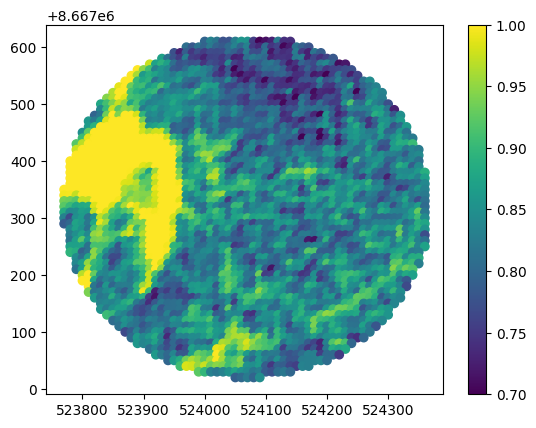

In [4]:
# Define a KD-tree using x_s2_condition and y_s2_condition
tree = cKDTree(list(zip(x_s2_condition, y_s2_condition)))

# Query the tree to find all points within x_s3_condition and y_s3_condition grids
ss3=1
indices_within_grid = tree.query_ball_point(list(zip(x_s3_condition[::ss3], y_s3_condition[::ss3])), r=300.0)

# Check the length of pixel indices within grid
print(f'Indices within grid length:',len(indices_within_grid))

# Here are the indices of the S2 pixels within 300 m of pixel 500 of S3
print (f'Example indices shape:',y_s2_condition[indices_within_grid[500]].shape)

#And here they are plotted
index_s3=500
plt.scatter(x_s2_condition[indices_within_grid[index_s3]],y_s2_condition[indices_within_grid[index_s3]],c=band_stack_condition[indices_within_grid[index_s3]],vmin=0.7,vmax=1)
plt.colorbar()

The following code is to obatin the initial training dataset by colocating the sea ice classified Sentinel-2 pixels into Sentinel-3 image.

In [5]:
# Calculate the average of classified Sentinel-2 labels within the 300 m radius for each pixel in Sentinel-3 image
SICavg=[]
for i in range(len(x_s3_condition)):
      SICavg.append(np.mean(labels[indices_within_grid[i]]))

# Print and check the results
for i, avg in enumerate(SICavg):
    print(f"S3 pixel {i} has an average label value of {avg}")

# Save the dataset for further analysis
path = '/Users/rhoswen/Desktop/Year_3/GEOL0069/Week_6/'
np.save(path+'SICavg_condition.npy',np.asarray(SICavg))

S3 pixel 0 has an average label value of 0.9111016588685665
S3 pixel 1 has an average label value of 0.8902187371027651
S3 pixel 2 has an average label value of 0.913588850174216
S3 pixel 3 has an average label value of 0.9075892857142858
S3 pixel 4 has an average label value of 0.8969181721572795
S3 pixel 5 has an average label value of 0.9032258064516129
S3 pixel 6 has an average label value of 0.9268385140257771
S3 pixel 7 has an average label value of 0.9136939010356732
S3 pixel 8 has an average label value of 0.8923366243535495
S3 pixel 9 has an average label value of 0.916135881104034
S3 pixel 10 has an average label value of 0.9006013441811107
S3 pixel 11 has an average label value of 0.9135977337110481
S3 pixel 12 has an average label value of 0.9349133356915458
S3 pixel 13 has an average label value of 0.9023954236682159
S3 pixel 14 has an average label value of 0.8392680514342236
S3 pixel 15 has an average label value of 0.8379052369077307
S3 pixel 16 has an average label val